<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Structure_Relaxation_Phonons_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examples how to use ALIGNN-FF (https://doi.org/10.1039/D2DD00096B) Pre-trained model

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


Installation with conda

In [1]:
%%time

!conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda phonopy -c pytorch -c nvidia --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - dgl=2.1.0
    - phonopy
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    alignn-2024.5.27           |     pyhd8ed1ab_0          72 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_0          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    blinke

Import necessary libraries

In [2]:
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import (
    phonons,
    ForceField,
    AlignnAtomwiseCalculator,
    default_path,
)
from jarvis.db.figshare import get_jid_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, get_supercell_dims
from tqdm import tqdm
from ase.constraints import ExpCellFilter
from sklearn.metrics import mean_absolute_error
import time
from jarvis.core.atoms import ase_to_atoms
from ase.optimize.fire import FIRE
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution



DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


A few examples of metals, semiconductors and insulators

In [3]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]


In [4]:
def general_relaxer(atoms="", calculator="", fmax=0.05, steps=150):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms)

    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=steps)
    return ase_to_atoms(ase_atoms.atoms)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v5.27.2024


  0%|          | 0/36 [00:00<?, ?it/s]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 08:49:37       -7.920191        0.356293
FIRE:    1 08:49:38       -7.944047        0.312202
FIRE:    2 08:49:40       -7.980646        0.232864
FIRE:    3 08:49:41       -8.014786        0.144871
FIRE:    4 08:49:42       -8.037722        0.073753
FIRE:    5 08:49:43       -8.048143        0.017750
7.051942586898804 System
1.0
3.226478031404403 2.1747568423234985e-07 1.8628077613645537
1.075492534752419 3.0419528558728444 1.8628078068694012
5.019345890410827e-07 4.1065315392240886e-07 3.725615616797506
Si 
2 
direct
0.8749991030864465 0.8750003229200822 0.8749976204511795 Si
0.12500014186076486 0.12500028231206745 0.12499958271042871 Si




100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


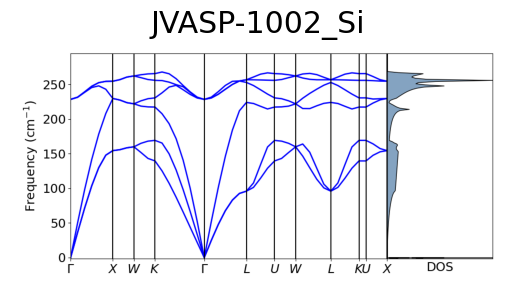

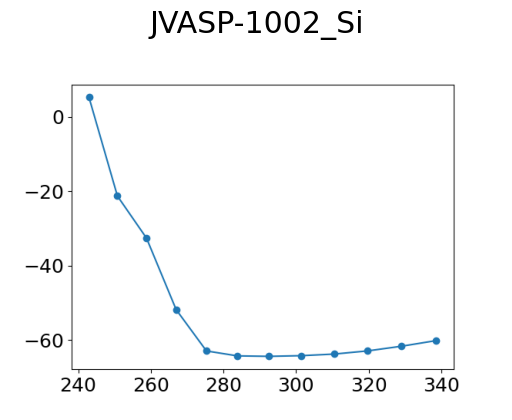

  3%|▎         | 1/36 [00:52<30:33, 52.39s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al

      Step     Time          Energy          fmax
FIRE:    0 08:50:30       -1.735909        0.437884
FIRE:    1 08:50:31       -1.753407        0.362565
FIRE:    2 08:50:32       -1.779459        0.304392
FIRE:    3 08:50:33       -1.817032        0.380842
FIRE:    4 08:50:34       -1.872596        0.285633
FIRE:    5 08:50:35       -1.913544        0.172639
FIRE:    6 08:50:36       -1.937595        0.054591
FIRE:    7 08:50:37       -1.937462        0.043866
8.596539497375488 System
1.0
2.253084778735073 5.135242936521337e-07 1.3008184286700677
0.7510287368778009 2.124228523104613 1.300818440544862
-1.


100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


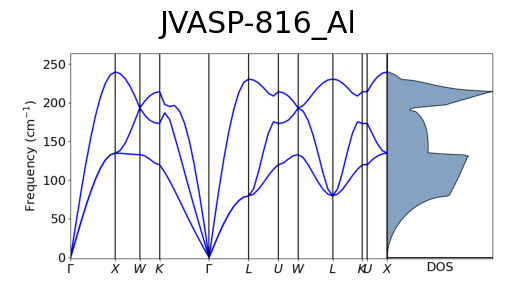

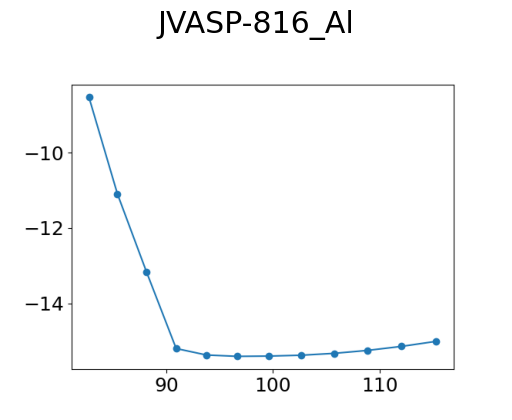

  6%|▌         | 2/36 [01:34<26:22, 46.55s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu

      Step     Time          Energy          fmax
FIRE:    0 08:51:12        1.659376        0.466345
FIRE:    1 08:51:12        1.638974        0.411456
FIRE:    2 08:51:14        1.603758        0.411638
FIRE:    3 08:51:15        1.706771        0.641429
FIRE:    4 08:51:17        1.626844        0.274543
FIRE:    5 08:51:18        1.561099        0.304907
FIRE:    6 08:51:19        1.504500        0.141669
FIRE:    7 08:51:20        1.481813        0.009901
9.645652770996094 System
1.0
1.955673725653762 5.0982467613357196e-05 1.1292199


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


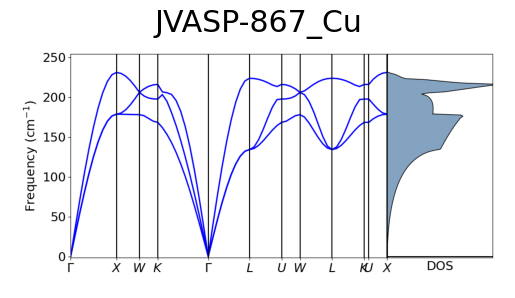

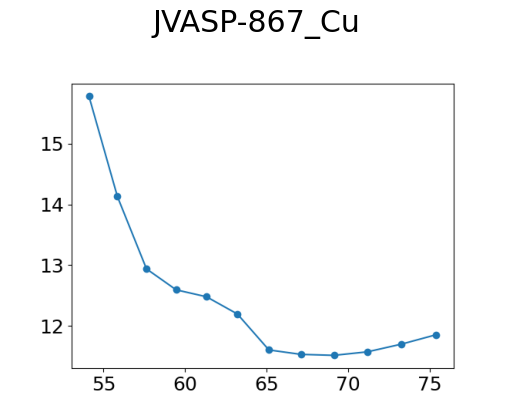

  8%|▊         | 3/36 [02:24<26:17, 47.82s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.273420132082977 -3.9376803190778005 0.0
2.2734201320829777 3.9376803190778005 0.0
0.0 0.0 2.820165120472419
Ti 
3 
direct
0.0 0.0 0.0 Ti
0.3333330000000032 0.6666669999999968 0.49999999999999994 Ti
0.6666669999999968 0.3333330000000032 0.49999999999999994 Ti

      Step     Time          Energy          fmax
FIRE:    0 08:52:02      -12.563596        0.429326
FIRE:    1 08:52:03      -12.609097        0.358583
FIRE:    2 08:52:04      -12.672034        0.247979
FIRE:    3 08:52:06      -12.728208        0.168658
FIRE:    4 08:52:07      -12.781692        0.168471
FIRE:    5 08:52:08      -12.859875        0.254751
FIRE:    6 08:52:10      -12.911283        0.283681
FIRE:    7 08:52:12      -12.343509        0.255845
FIRE:    8 08:52:14      -12.073893        0.159155
FIRE:    9 08:52:1


100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


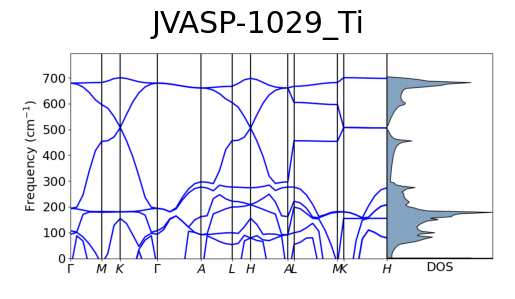

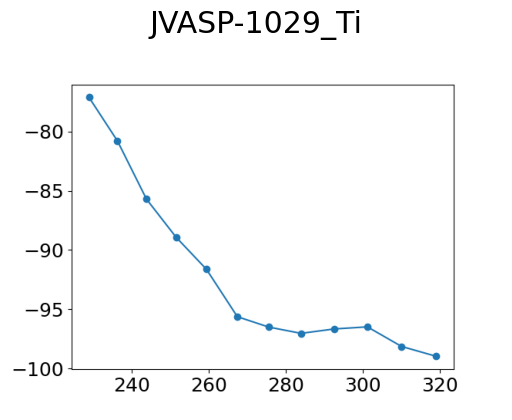

 11%|█         | 4/36 [04:23<40:28, 75.90s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.319094407092078 -9.102157442e-07 -0.8199242029800663
-1.1595485232749354 2.008394485299467 -0.819924296058508
-6.881171935e-07 -1.3067001075e-06 2.4597716564905787
Cr 
1 
direct
1.619573e-10 1.7354659999999999e-10 8.038694e-10 Cr

      Step     Time          Energy          fmax
FIRE:    0 08:54:00       -5.206606        0.901022
FIRE:    1 08:54:02       -5.292755        0.962926
FIRE:    2 08:54:03       -5.361272        0.920385
FIRE:    3 08:54:05       -5.383541        0.801559
FIRE:    4 08:54:06       -5.391360        0.374045
FIRE:    5 08:54:07       -5.392201        0.329834
FIRE:    6 08:54:09       -5.393481        0.238127
FIRE:    7 08:54:10       -5.394502        0.097360
FIRE:    8 08:54:11       -5.394567        0.081118
FIRE:    9 08:54:12       -5.394574        0.07


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


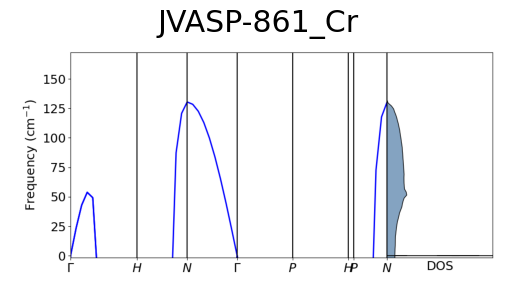

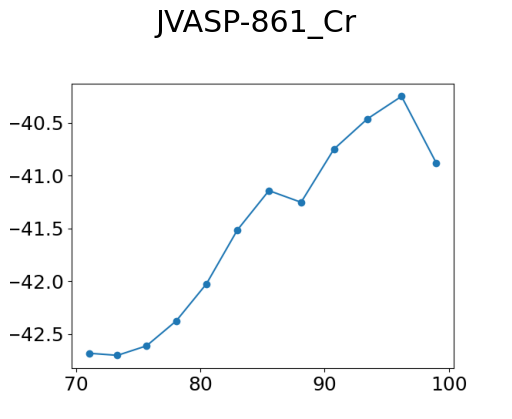

 14%|█▍        | 5/36 [05:18<35:26, 68.59s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6056404666190551 -2.781051020215259 0.0
1.6056404666190551 2.781051020215259 0.0
0.0 0.0 5.240440132796911
Ga N 
2 2 
direct
0.3333330000000032 0.6666669999999968 0.5005859179897493 Ga
0.6666669999999968 0.3333330000000032 0.0005859179897492 Ga
0.3333330000000032 0.6666669999999968 0.12441408201025081 N
0.6666669999999968 0.3333330000000032 0.6244140820102507 N

      Step     Time          Energy          fmax
FIRE:    0 08:54:57      -11.271260        0.696042
FIRE:    1 08:54:59      -11.374822        0.762190
FIRE:    2 08:55:01      -11.534924        0.593254
FIRE:    3 08:55:04      -11.638243        0.276584
FIRE:    4 08:55:06      -11.641369        0.254273
FIRE:    5 08:55:09      -11.647305        0.211036
FIRE:    6 08:55:11      -11.655490        0.174526
FIRE:    7 08:55:


100%|██████████| 12/12 [00:27<00:00,  2.28s/it]


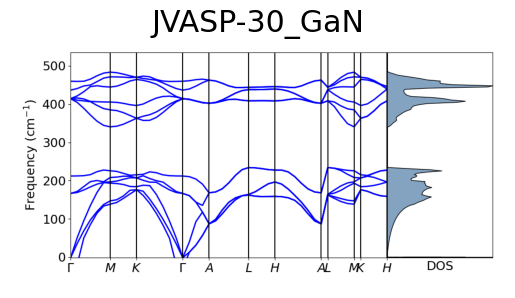

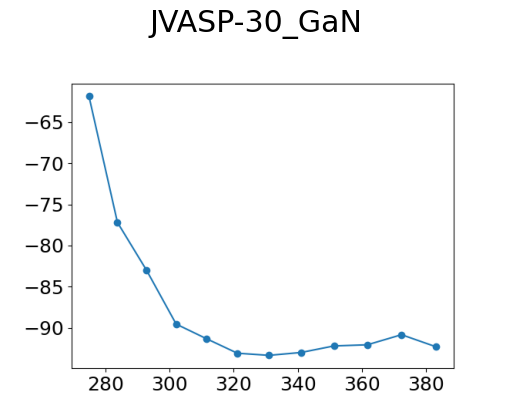

 17%|█▋        | 6/36 [07:46<47:41, 95.39s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7805059713099647 0.0 1.6053257450263214
0.9268353237699882 2.621486121264764 1.6053257450263214
-0.0 0.0 3.210651490052643
Ga N 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.25 N

      Step     Time          Energy          fmax
FIRE:    0 08:57:24       -5.694012        0.443657
FIRE:    1 08:57:26       -5.732147        0.409457
FIRE:    2 08:57:28       -5.793301        0.299675
FIRE:    3 08:57:29       -5.848245        0.171373
FIRE:    4 08:57:31       -5.873250        0.001133
8.239433288574219 System
1.0
2.6755780861112033 4.769015061319847e-07 1.544746272088835
0.8918597750630562 2.5225593161883895 1.5447463354837263
4.1293102499823737e-07 3.696288961086036e-07 3.0894918289600986
Ga N 
1 1 
direct
-1.4917893242431144e-06 -9.275423727131917e-07 4.6668696602403997e-07 Ga
0.2500019839


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


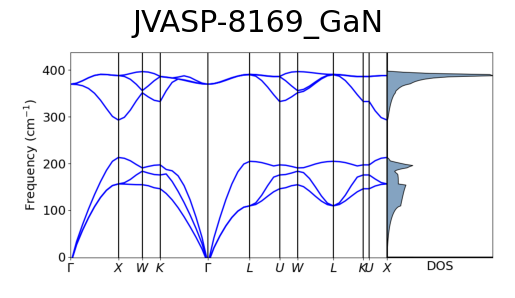

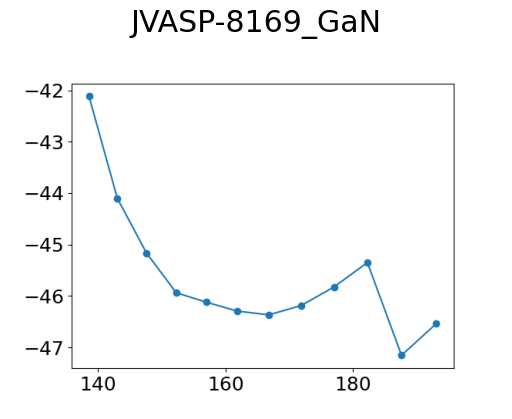

 19%|█▉        | 7/36 [08:47<40:44, 84.31s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5261943628070638 1.196611e-10 2.035849771621022
1.1753977879818787 3.3245278496612793 2.035849771621022
-4.62335e-10 -3.269202e-10 4.071698544842951
Ge 
2 
direct
0.875 0.875 0.8749999999999999 Ge
0.125 0.125 0.12499999999999999 Ge

      Step     Time          Energy          fmax
FIRE:    0 08:58:25       -1.803490        0.148386
FIRE:    1 08:58:26       -1.807764        0.139526
FIRE:    2 08:58:26       -1.815359        0.123868
FIRE:    3 08:58:27       -1.824809        0.104770
FIRE:    4 08:58:28       -1.834708        0.085565
FIRE:    5 08:58:29       -1.844082        0.068313
FIRE:    6 08:58:30       -1.852393        0.053379
FIRE:    7 08:58:31       -1.859325        0.039764
7.400228977203369 System
1.0
3.4076806912261532 -9.63736255104821e-08 1.967425626236258
1.1358931


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


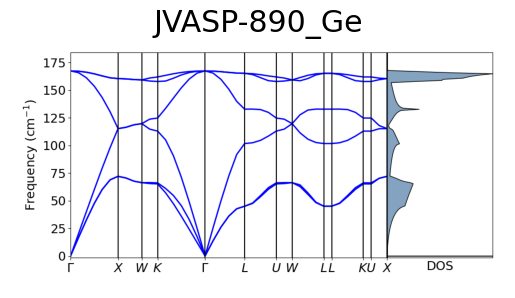

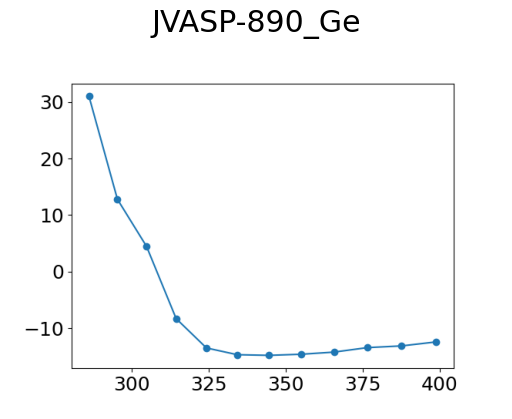

 22%|██▏       | 8/36 [09:41<34:45, 74.49s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6869744850745265 -3.845503e-10 1.5513250526772773
0.8956581613289514 2.533303526984513 1.5513250526772773
-1.087673e-09 -7.691009e-10 3.1026511091223643
Si C 
1 1 
direct
0.24999999999999997 0.25 0.25 Si
0.0 0.0 0.0 C

      Step     Time          Energy          fmax
FIRE:    0 08:59:19      -10.721274        0.253653
FIRE:    1 08:59:20      -10.733555        0.229791
FIRE:    2 08:59:21      -10.753519        0.179832
FIRE:    3 08:59:23      -10.772517        0.103398
FIRE:    4 08:59:24      -10.782557        0.031056
7.309685945510864 System
1.0
2.6287471845826986 3.0205776175299776e-07 1.5177078143296425
0.8762493514484623 2.47840661700067 1.5177078054301163
5.696972071738749e-07 3.919371573558779e-07 3.0354156220875947
Si C 
1 1 
direct
0.2499998063906201 0.2499993195151186 0.2


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


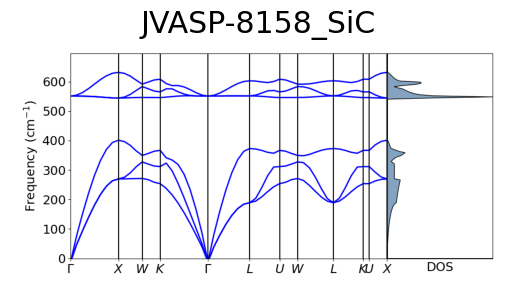

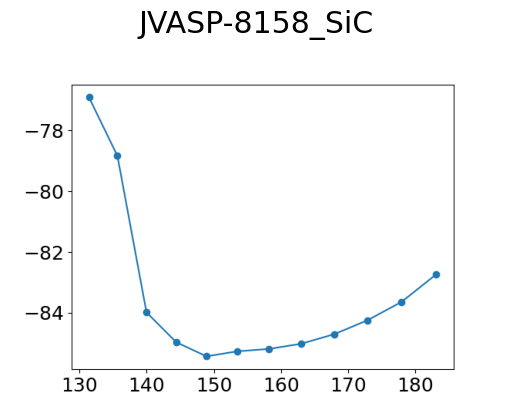

 25%|██▌       | 9/36 [10:47<32:23, 71.99s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5486099089372707 -2.6822705642693716 -0.0
1.5486099089372707 2.6822705642693716 0.0
0.0 0.0 5.086303822948022
Si C 
2 2 
direct
0.3333330000000032 0.6666669999999967 0.49966399499258707 Si
0.6666669999999968 0.33333300000000315 0.9996639949925871 Si
0.3333330000000032 0.6666669999999967 0.8753360050074128 C
0.6666669999999968 0.33333300000000315 0.3753360050074129 C

      Step     Time          Energy          fmax
FIRE:    0 09:00:27      -20.822903        1.138692
FIRE:    1 09:00:30      -20.919022        1.296415
FIRE:    2 09:00:33      -21.092983        0.895709
FIRE:    3 09:00:37      -21.170959        0.391614
FIRE:    4 09:00:40      -21.174618        0.368285
FIRE:    5 09:00:42      -21.181568        0.320424
FIRE:    6 09:00:45      -21.191116        0.244426
FIRE:    7 0


100%|██████████| 12/12 [00:52<00:00,  4.34s/it]


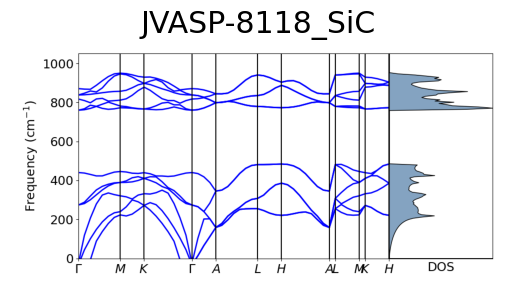

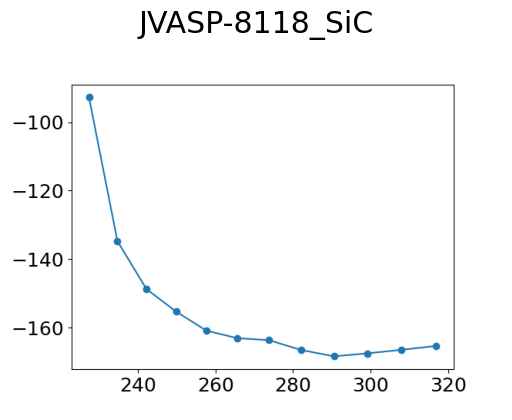

 28%|██▊       | 10/36 [17:19<1:14:00, 170.80s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.549892767326361 -2.684493224977372 0.0
1.549892767326361 2.684493224977372 0.0
0.0 0.0 10.151391815821647
Si C 
4 4 
direct
0.6666669999999968 0.3333330000000032 0.9378471697430678 Si
0.3333330000000032 0.6666669999999968 0.4378471697430677 Si
0.0 0.0 0.687848348838534 Si
0.0 0.0 0.1878483488385339 Si
0.6666669999999968 0.3333330000000032 0.7498261639014804 C
0.3333330000000032 0.6666669999999968 0.2498261639014804 C
0.0 0.0 0.5004783175169156 C
0.0 0.0 0.0004783175169156 C

      Step     Time          Energy          fmax
FIRE:    0 09:06:58      -41.975761        1.218905
FIRE:    1 09:07:02      -42.088249        1.317032
FIRE:    2 09:07:06      -42.294518        1.052450
FIRE:    3 09:07:11      -42.468796        0.347104
FIRE:    4 09:07:15      -42.473793        0.338366
FIRE: 


100%|██████████| 12/12 [01:52<00:00,  9.36s/it]


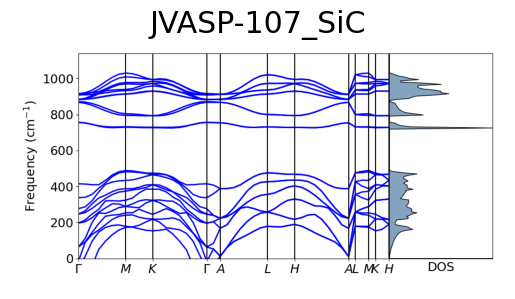

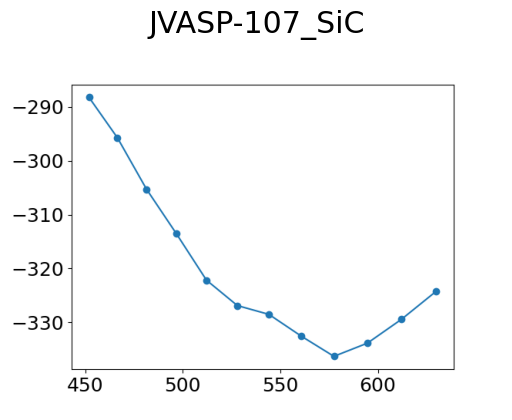

 31%|███       | 11/36 [28:21<2:13:46, 321.05s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5650222970111176 -2.7106984478647482 0.0
1.5650222970111176 2.7106984478647482 0.0
0.0 0.0 5.021252677842383
Al N 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4993312971779396 Al
0.3333330000000032 0.6666669999999968 0.9993312971779398 Al
0.6666669999999968 0.3333330000000032 0.8806687028220628 N
0.3333330000000032 0.6666669999999968 0.380668702822063 N

      Step     Time          Energy          fmax
FIRE:    0 09:18:00      -19.211407        0.593681
FIRE:    1 09:18:02      -19.301949        0.640888
FIRE:    2 09:18:04      -19.320503        0.477857
FIRE:    3 09:18:07      -19.499674        0.399509
FIRE:    4 09:18:09      -19.676449        0.317951
FIRE:    5 09:18:13      -19.880367        0.333191
FIRE:    6 09:18:15      -19.421711        2.339057
FIRE:    7 09:18:


100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


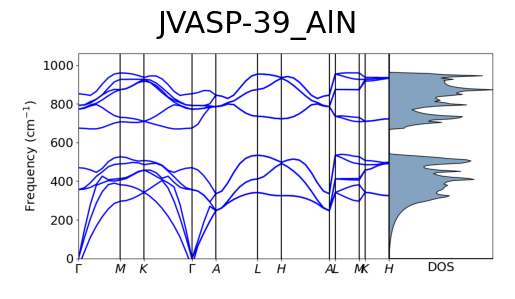

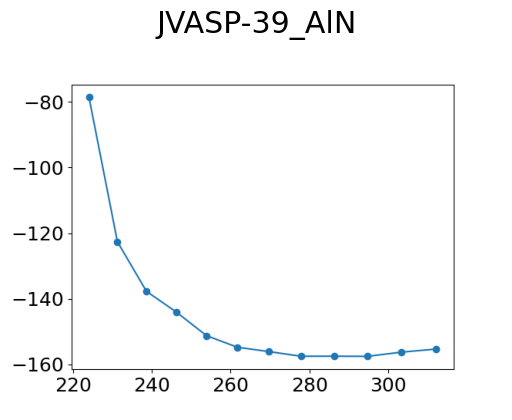

 33%|███▎      | 12/36 [32:10<1:57:15, 293.14s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6966971014488705 1.040645e-10 1.5569393383280248
0.8988990339144031 2.5424705153968894 1.5569393383280248
2.943387e-10 2.081289e-10 3.1138776756364304
Al N 
1 1 
direct
0.0 0.0 0.0 Al
0.25 0.25 0.24999999999999997 N

      Step     Time          Energy          fmax
FIRE:    0 09:21:48       -9.766151        0.334801
FIRE:    1 09:21:50       -9.789196        0.352467
FIRE:    2 09:21:51       -9.840185        0.382221
FIRE:    3 09:21:52       -9.926593        0.413447
FIRE:    4 09:21:54      -10.063055        0.481645
FIRE:    5 09:21:55      -10.240082        0.327411
FIRE:    6 09:21:57      -10.001152        0.084706
FIRE:    7 09:22:00       -9.951082        0.356303
FIRE:    8 09:22:03       -9.957911        0.332210
FIRE:    9 09:22:05       -9.969734        0.285979
FIRE:   1


100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


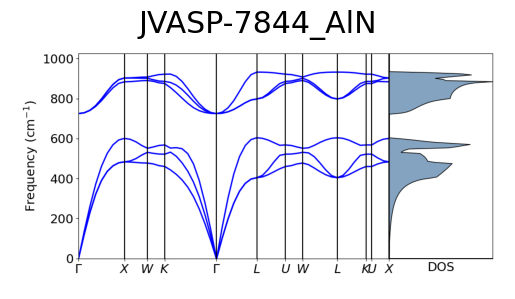

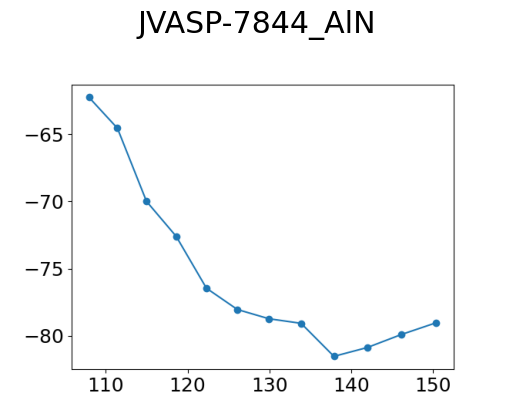

 36%|███▌      | 13/36 [33:56<1:30:36, 236.35s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.4378970432125495 -0.0 -0.0
-0.0 4.4378970432125495 -0.0
0.0 0.0 4.4378970432125495
Al Ga N 
3 1 4 
direct
0.5 0.5 0.0 Al
0.5 0.0 0.5 Al
0.0 0.5 0.5 Al
0.0 0.0 0.0 Ga
0.7439495711598934 0.7439495711598934 0.2560504288401067 N
0.7439495711598934 0.2560504288401067 0.7439495711598934 N
0.2560504288401067 0.7439495711598934 0.7439495711598934 N
0.2560504288401067 0.2560504288401067 0.2560504288401067 N

      Step     Time          Energy          fmax
FIRE:    0 09:23:38      -34.746880        0.563518
FIRE:    1 09:23:42      -35.001007        0.555337
FIRE:    2 09:23:45      -35.469872        0.529829
FIRE:    3 09:23:49      -35.976299        0.353882
FIRE:    4 09:23:53      -36.530315        0.355921
FIRE:    5 09:23:57      -37.030197        0.110755
FIRE:    6 09:24:03      -34.37


100%|██████████| 12/12 [01:50<00:00,  9.20s/it]


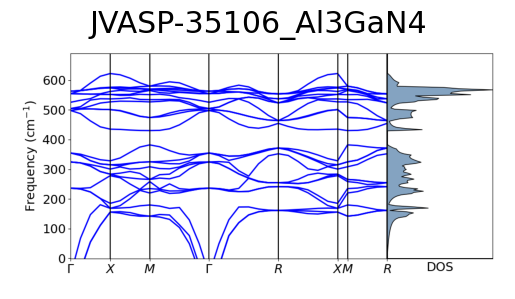

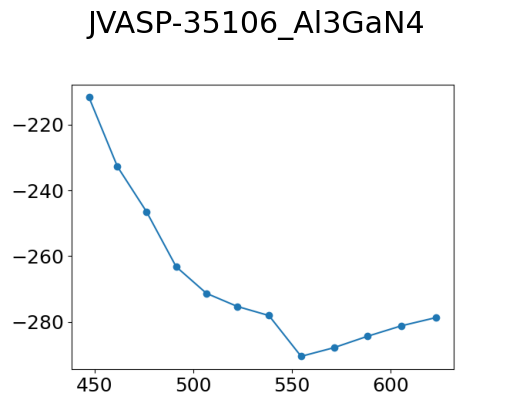

 39%|███▉      | 14/36 [40:41<1:45:17, 287.18s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 As

      Step     Time          Energy          fmax
FIRE:    0 09:30:19       -2.685096        0.092692
FIRE:    1 09:30:19       -2.686788        0.089790
FIRE:    2 09:30:20       -2.689968        0.084167
FIRE:    3 09:30:21       -2.694257        0.076067
FIRE:    4 09:30:22       -2.699147        0.065545
FIRE:    5 09:30:23       -2.704010        0.051973
FIRE:    6 09:30:25       -2.708046        0.033712
6.978348970413208 System
1.0
3.4483669828353993 -5.060021705262715e-07 1.9909153259557784
1.1494551818387613 3.251150751852872 1.990915329494313
-3.578437226926018


100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


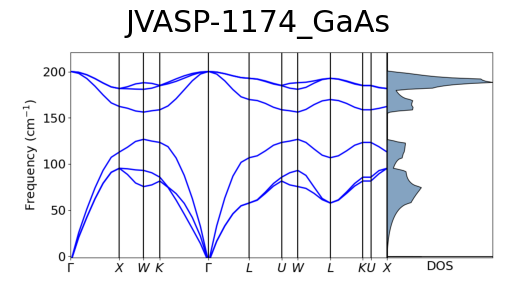

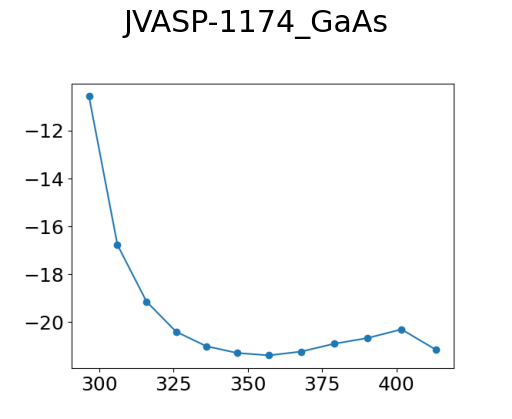

 42%|████▏     | 15/36 [41:34<1:15:49, 216.66s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5058938597621094 -3.081249e-10 2.0241289627124215
1.1686312862968669 3.3053879820023613 2.0241289627124215
-8.715088e-10 -6.162497e-10 4.048256928443838
Al As 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.24999999999999997 As

      Step     Time          Energy          fmax
FIRE:    0 09:31:12       -5.604784        0.140868
FIRE:    1 09:31:13       -5.608793        0.143655
FIRE:    2 09:31:13       -5.617200        0.151394
FIRE:    3 09:31:14       -5.631051        0.163774
FIRE:    4 09:31:15       -5.651476        0.169912
FIRE:    5 09:31:16       -5.677137        0.153672
FIRE:    6 09:31:17       -5.703438        0.125394
FIRE:    7 09:31:18       -5.728635        0.104713
FIRE:    8 09:31:20       -5.745733        0.003710
9.12220048904419 System
1.0
3.313675336207


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


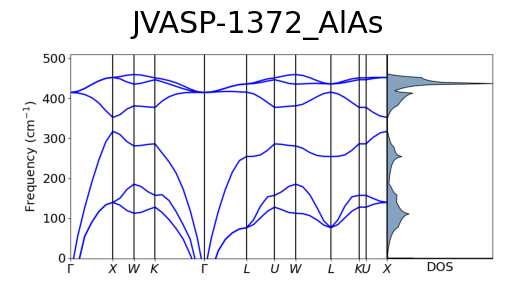

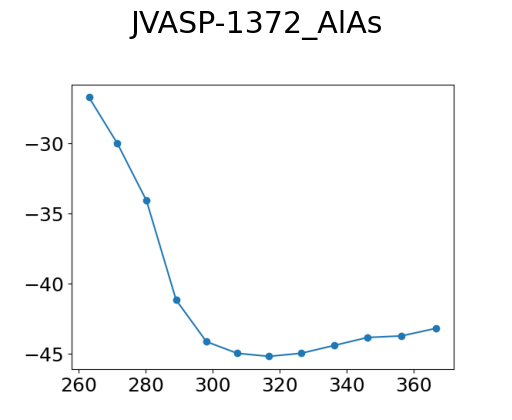

 44%|████▍     | 16/36 [42:29<56:01, 168.07s/it]  

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.1874686952597293 -1.033047e-10 1.2629352933595248
0.7291565647587371 2.062365242524199 1.2629352933595248
3.991386e-10 2.822336e-10 2.525871585336393
C 
2 
direct
0.875 0.8750000000000001 0.8749999999999998 C
0.12499999999999999 0.125 0.12500000000000003 C

      Step     Time          Energy          fmax
FIRE:    0 09:32:08      -13.146734        1.036144
FIRE:    1 09:32:12      -13.066883        1.032138
FIRE:    2 09:32:15      -13.396080        0.496563
FIRE:    3 09:32:21      -13.285690        0.642650
FIRE:    4 09:32:28      -13.326971        0.353651
FIRE:    5 09:32:36      -13.333792        0.349173
FIRE:    6 09:32:43      -13.346996        0.336371
FIRE:    7 09:32:51      -13.365242        0.303374
FIRE:    8 09:32:58      -13.384928        0.229251
FIRE:    9 09:33:05 


100%|██████████| 12/12 [01:34<00:00,  7.90s/it]


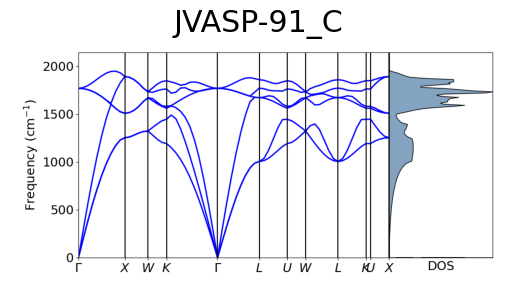

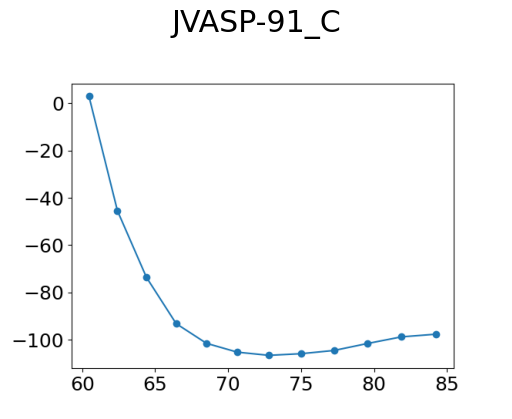

 47%|████▋     | 17/36 [46:32<1:00:22, 190.63s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7780018042176415 3.971646e-10 2.1812297047669467
1.2593339351136643 3.5619340280528164 2.1812297047669467
1.1233515e-09 7.943294e-10 4.36246040564249
In As 
1 1 
direct
0.25 0.25 0.25 In
0.0 0.0 0.0 As

      Step     Time          Energy          fmax
FIRE:    0 09:36:11       -2.824859        0.063477
FIRE:    1 09:36:11       -2.825658        0.062460
FIRE:    2 09:36:12       -2.827207        0.060313
FIRE:    3 09:36:13       -2.829395        0.056748
FIRE:    4 09:36:14       -2.832036        0.051232
FIRE:    5 09:36:14       -2.834840        0.043037
4.480824947357178 System
1.0
3.7435127084096274 1.3244835150629997e-07 2.1613176401871304
1.2478376937083901 3.5294174276650856 2.1613176412869506
1.0620719560074303e-07 7.644683156091506e-08 4.322636085361182
In As 
1 1 
direct
0.


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


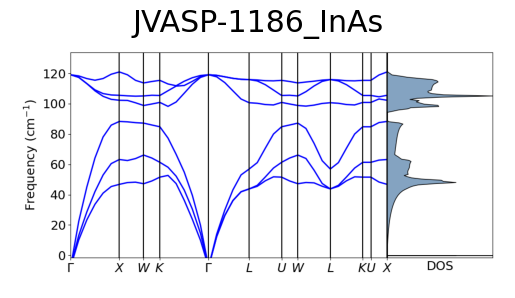

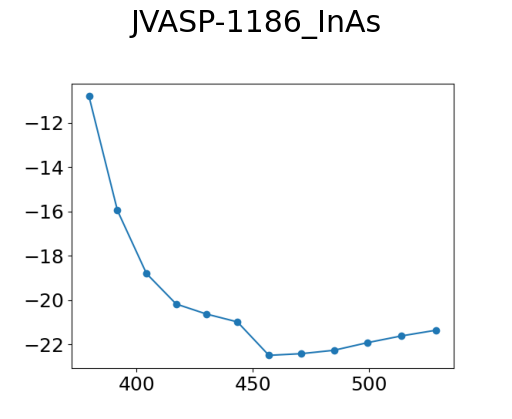

 50%|█████     | 18/36 [47:22<44:32, 148.47s/it]  

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.812447552586739 0.0 2.201117518505527
1.2708158508622465 3.5944098163596645 2.201117518505527
0.0 0.0 4.402235037011054
Al Sb 
1 1 
direct
0.0 0.0 0.0 Al
0.25000000000000006 0.25 0.24999999999999994 Sb

      Step     Time          Energy          fmax
FIRE:    0 09:36:59       -4.783445        0.055014
FIRE:    1 09:37:00       -4.784050        0.054828
FIRE:    2 09:37:01       -4.785253        0.054543
FIRE:    3 09:37:02       -4.787045        0.054259
FIRE:    4 09:37:03       -4.789420        0.053878
FIRE:    5 09:37:03       -4.792350        0.052640
FIRE:    6 09:37:04       -4.795689        0.048378
6.130007266998291 System
1.0
3.7687738830801254 -3.487958498568962e-07 2.1759019617521305
1.2562576285691283 3.5532335957782357 2.1759019680043443
-3.2336249589619607e-07 -2.20994


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


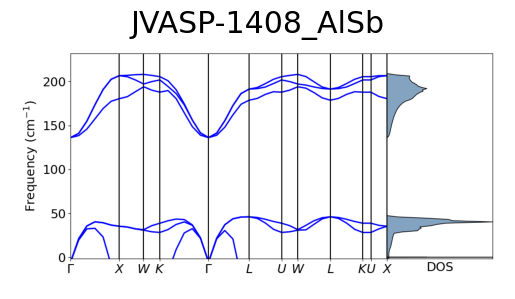

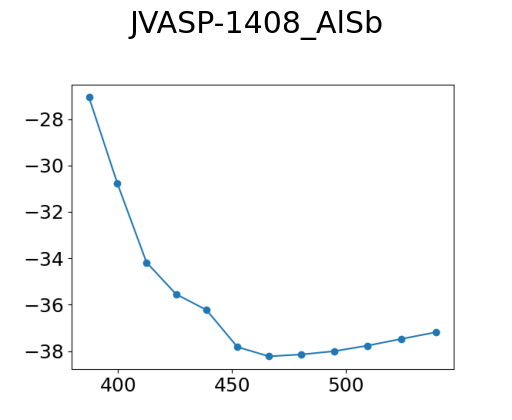

 53%|█████▎    | 19/36 [48:11<33:34, 118.47s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.4247492813810294 -0.0 1.9772799195123152
1.1415830937936766 3.2288845876377086 1.9772799195123152
0.0 0.0 3.9545598390246295
Si Ge 
1 1 
direct
0.0 0.0 0.0 Si
0.24999999999999997 0.25 0.25 Ge

      Step     Time          Energy          fmax
FIRE:    0 09:37:49       -4.810681        0.094810
FIRE:    1 09:37:50       -4.812459        0.092312
FIRE:    2 09:37:51       -4.815826        0.087627
FIRE:    3 09:37:52       -4.820487        0.081286
FIRE:    4 09:37:54       -4.826042        0.073830
FIRE:    5 09:37:55       -4.832109        0.065723
FIRE:    6 09:37:56       -4.838289        0.057166
FIRE:    7 09:37:57       -4.844231        0.048169
8.78739595413208 System
1.0
3.342866430954564 2.0824703941752918e-09 1.9300049487570778
1.114288805232874 3.151684702458737 1.93000496096


100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


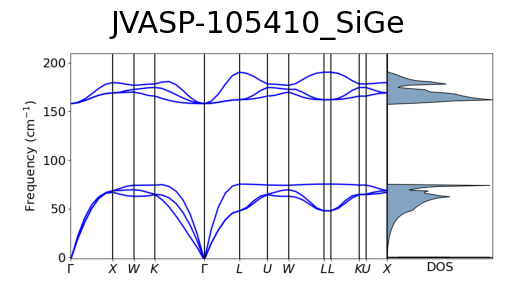

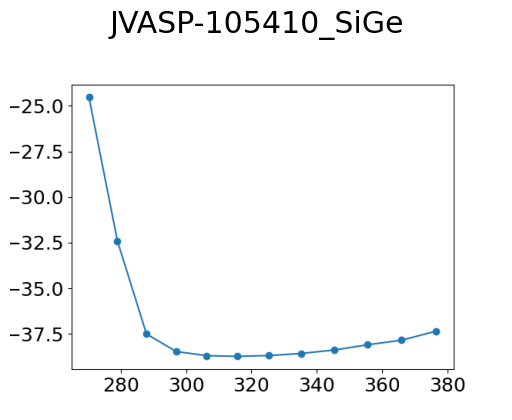

 56%|█████▌    | 20/36 [49:06<26:31, 99.48s/it] 

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7936820025137235 0.0 2.1902833745675476
1.2645606675045744 3.5767177657951077 2.1902833745675476
0.0 0.0 4.380566749135095
Ga Sb 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 Sb

      Step     Time          Energy          fmax
FIRE:    0 09:38:43       -1.778121        0.065798
FIRE:    1 09:38:44       -1.778993        0.066662
FIRE:    2 09:38:44       -1.780785        0.068472
FIRE:    3 09:38:45       -1.783601        0.071214
FIRE:    4 09:38:46       -1.787586        0.074253
FIRE:    5 09:38:47       -1.792835        0.075257
FIRE:    6 09:38:49       -1.799067        0.069237
FIRE:    7 09:38:50       -1.805172        0.051344
FIRE:    8 09:38:50       -1.809663        0.021228
8.000854730606079 System
1.0
3.697611309190401 -3.6127835703348374e-08 2.13481687390799


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


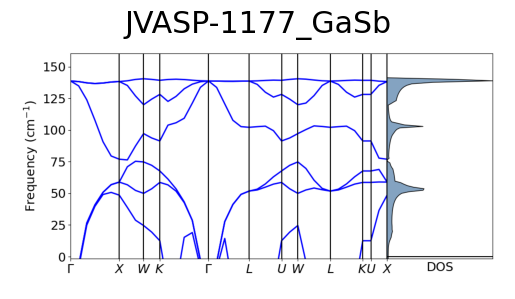

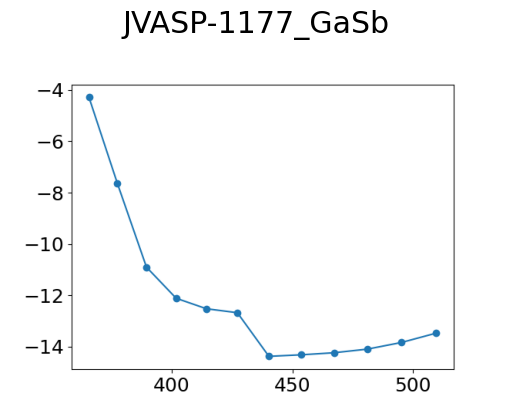

 58%|█████▊    | 21/36 [49:59<21:20, 85.38s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
-1.277108777115828 -2.212016741513634 0.0
-1.277108777115828 2.212016741513634 0.0
0.0 0.0 -4.2256495453427245
B N 
2 2 
direct
0.3333334206123232 0.6666665793876768 0.49976924795093536 B
0.6666665793876768 0.3333334206123232 0.9997692479509354 B
0.33333286818127345 0.6666671318187268 0.1252307520490646 N
0.6666671318187268 0.33333286818127345 0.6252307520490646 N

      Step     Time          Energy          fmax
FIRE:    0 09:39:42      -26.345100        0.995141
FIRE:    1 09:39:51      -26.395271        0.346381
FIRE:    2 09:39:59      -26.403576        0.336568
FIRE:    3 09:40:07      -26.419102        0.317334
FIRE:    4 09:40:16      -26.440102        0.288662
FIRE:    5 09:40:25      -26.464226        0.250145
FIRE:    6 09:40:33      -26.488495        0.202671
FIRE:    7 09:40


100%|██████████| 12/12 [02:03<00:00, 10.32s/it]


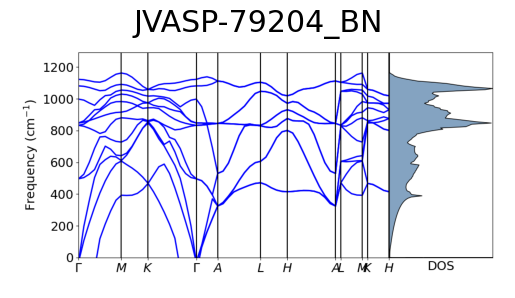

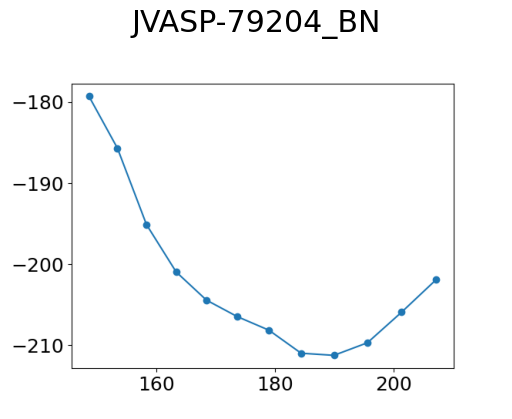

 61%|██████    | 22/36 [59:29<53:51, 230.83s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3677217590579 2.533606e-10 1.9443546507300569
1.1225739199248372 3.175118118429553 1.9443546507300566
7.166124e-10 5.067214e-10 3.888710298977696
Ga P 
1 1 
direct
0.0 0.0 0.0 Ga
0.24999999999999997 0.25 0.24999999999999997 P

      Step     Time          Energy          fmax
FIRE:    0 09:49:07       -3.669914        0.121406
FIRE:    1 09:49:08       -3.672743        0.111458
FIRE:    2 09:49:09       -3.677513        0.093045
FIRE:    3 09:49:10       -3.682837        0.070136
FIRE:    4 09:49:11       -3.687446        0.045609
4.573897361755371 System
1.0
3.3314776504879995 1.1783288225945931e-07 1.9234292949363212
1.110492671206684 3.14094709888541 1.923429277702195
1.4929324291703987e-07 8.445886707359828e-08 3.846859319299147
Ga P 
1 1 
direct
2.8228828344470703e-08 6.5922344241


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


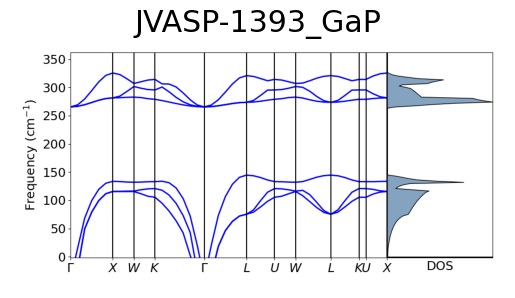

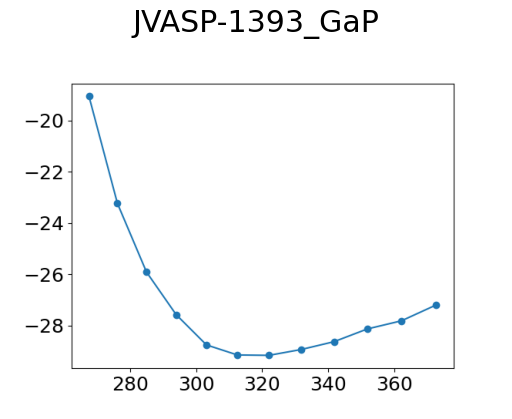

 64%|██████▍   | 23/36 [1:00:21<38:22, 177.10s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7886408016740347 -3.149311e-10 1.6100221817296598
0.9295469335944251 2.6291561224262785 1.6100221817296596
-8.907598e-10 -6.298624e-10 3.220045366545002
B P 
1 1 
direct
0.0 0.0 0.0 B
0.25 0.25 0.24999999999999994 P

      Step     Time          Energy          fmax
FIRE:    0 09:49:57       -9.422325        0.561449
FIRE:    1 09:49:59       -9.479757        0.458765
FIRE:    2 09:50:01       -9.557631        0.301432
FIRE:    3 09:50:02       -9.601561        0.018197
6.8275065422058105 System
1.0
2.7076786088515536 4.458510578463602e-07 1.5632791351403197
0.9025599622423665 2.5528238458510852 1.5632791254303564
3.7906761806060114e-07 2.5614901939978114e-07 3.126558586181629
B P 
1 1 
direct
-5.336148640591055e-07 -8.369473889981847e-07 6.476556975363409e-07 B
0.25000036702829953 0.2


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


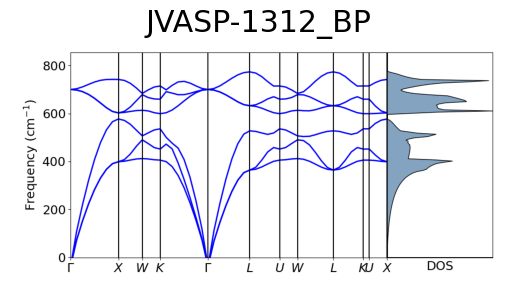

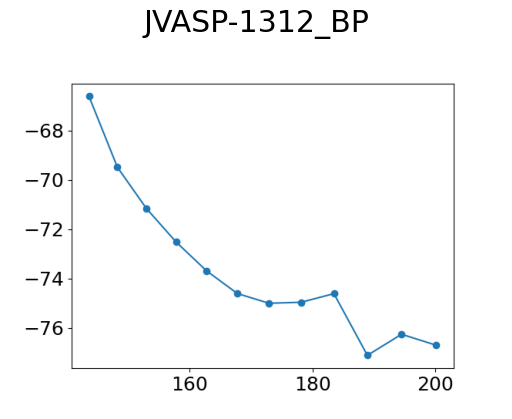

 67%|██████▋   | 24/36 [1:01:18<28:15, 141.28s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3768067453542683 1.950831e-10 1.9495999256867476
1.1256025824038562 3.1836839484367916 1.9495999256867473
-7.537433e-10 -5.329769e-10 3.8992008539845386
Al P 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.25000000000000006 P

      Step     Time          Energy          fmax
FIRE:    0 09:50:57       -6.563823        0.293364
FIRE:    1 09:50:57       -6.579859        0.253681
FIRE:    2 09:50:58       -6.604630        0.202089
FIRE:    3 09:50:59       -6.633355        0.187711
FIRE:    4 09:51:00       -6.674801        0.262184
FIRE:    5 09:51:01       -6.750885        0.276206
FIRE:    6 09:51:02       -6.745370        0.302807
FIRE:    7 09:51:04       -6.750065        0.284868
FIRE:    8 09:51:06       -6.758240        0.241937
FIRE:    9 09:51:07       -6.767125        0


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


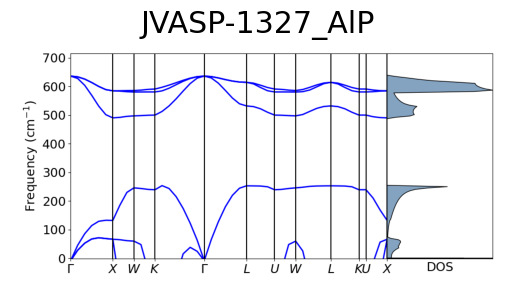

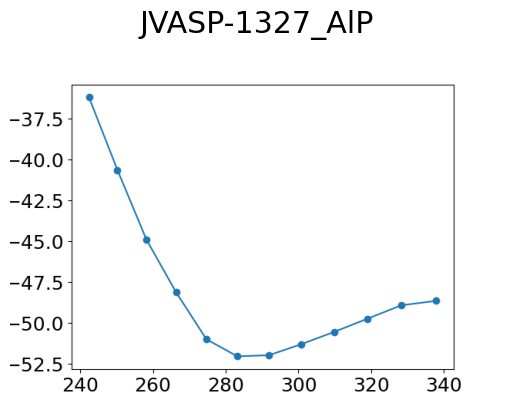

 69%|██████▉   | 25/36 [1:02:18<21:24, 116.77s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.646780655180086 1.457505e-10 2.1054695860995256
1.2155932186178946 3.4382181775806795 2.1054695860995256
1.50892e-10 1.066968e-10 4.210940171676346
In P 
1 1 
direct
0.0 0.0 0.0 In
0.25 0.25 0.25 P

      Step     Time          Energy          fmax
FIRE:    0 09:51:55       -3.343994        0.073727
FIRE:    1 09:51:56       -3.345084        0.074136
FIRE:    2 09:51:57       -3.347296        0.075330
FIRE:    3 09:51:58       -3.350724        0.077855
FIRE:    4 09:51:59       -3.355563        0.082012
FIRE:    5 09:52:00       -3.362105        0.086930
FIRE:    6 09:52:01       -3.370536        0.089057
FIRE:    7 09:52:03       -3.380505        0.085149
FIRE:    8 09:52:04       -3.392610        0.080174
FIRE:    9 09:52:05       -3.407767        0.081895
FIRE:   10 09:52:06       -


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


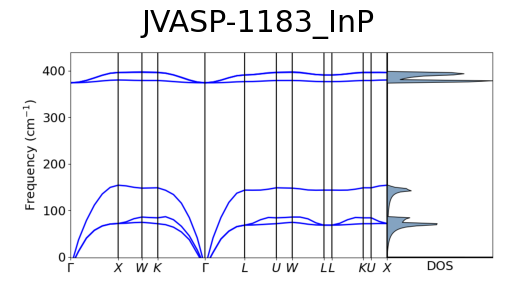

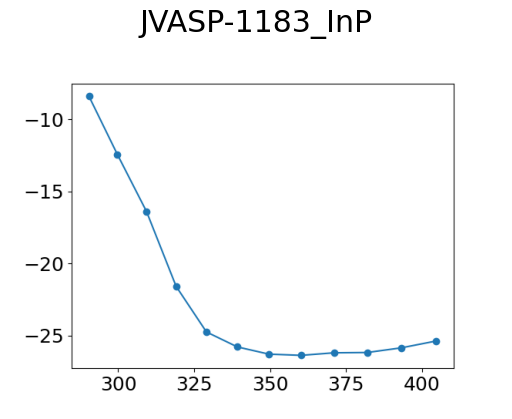

 72%|███████▏  | 26/36 [1:03:19<16:40, 100.09s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se

      Step     Time          Energy          fmax
FIRE:    0 09:52:57       -0.542158        0.000526
1.1549739837646484 System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se




100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


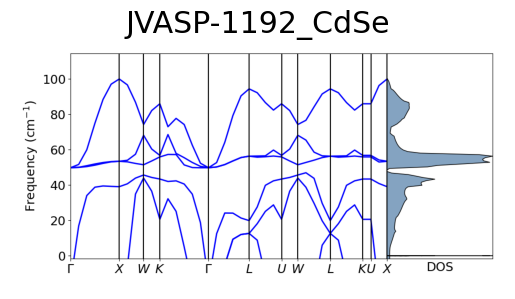

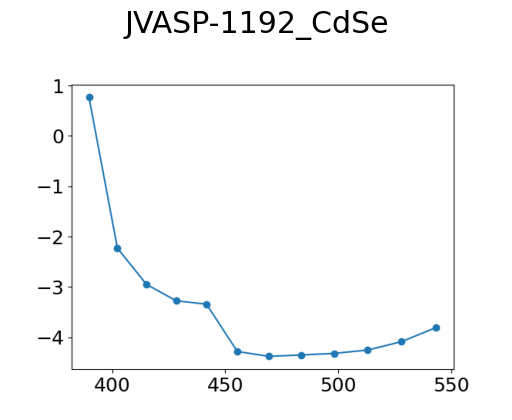

 75%|███████▌  | 27/36 [1:04:05<12:35, 83.95s/it] 

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.616656945344388 -2.0744814e-09 2.088077849798458
1.2055526445364497 3.409816748119369 2.088077849798458
0.0 0.0 4.176155699596916
Cd S 
1 1 
direct
0.0 0.0 0.0 Cd
0.25 0.24999999999999997 0.25 S

      Step     Time          Energy          fmax
FIRE:    0 09:53:48       -1.106986        0.085797
FIRE:    1 09:53:51       -1.108448        0.084547
FIRE:    2 09:53:53       -1.111289        0.081988
FIRE:    3 09:53:54       -1.115343        0.077962
FIRE:    4 09:53:55       -1.120340        0.072235
FIRE:    5 09:53:56       -1.125913        0.064676
FIRE:    6 09:53:57       -1.131610        0.055443
FIRE:    7 09:53:58       -1.136955        0.044736
12.209707260131836 System
1.0
3.535963674992571 -7.534547706549353e-08 2.041489531529459
1.1786548130719485 3.333738568296829 2.041489


100%|██████████| 12/12 [00:04<00:00,  2.97it/s]


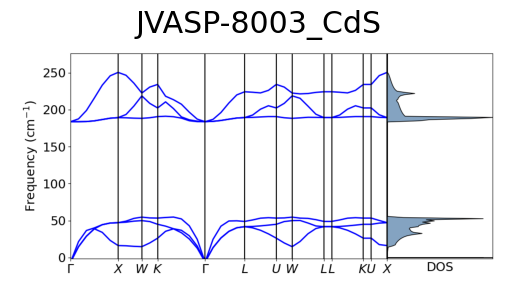

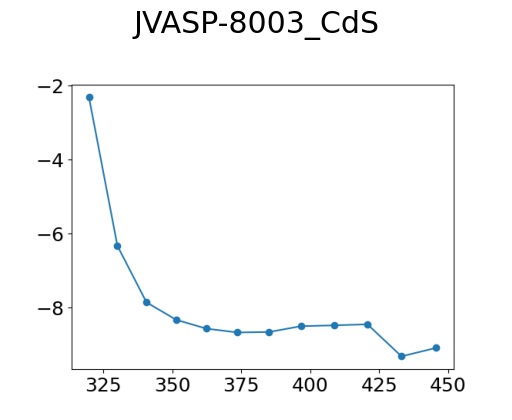

 78%|███████▊  | 28/36 [1:05:10<10:24, 78.07s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5008378901472135 6.634685e-10 2.0212097688704245
1.1669456321546012 3.300620830306097 2.0212097688704254
-2.5634453e-09 -1.8126293e-09 4.042418546620883
Zn Se 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Se

      Step     Time          Energy          fmax
FIRE:    0 09:54:48       -0.962033        0.105234
FIRE:    1 09:54:49       -0.964226        0.103012
FIRE:    2 09:54:50       -0.968428        0.098295
FIRE:    3 09:54:51       -0.974248        0.090552
FIRE:    4 09:54:52       -0.981062        0.079503
FIRE:    5 09:54:53       -0.988087        0.066180
FIRE:    6 09:54:54       -0.994632        0.052685
FIRE:    7 09:54:55       -1.000279        0.040351
8.80403447151184 System
1.0
3.408697671005367 -1.0630634573156868e-07 1.9680123726040657
1.1362321063079714 3


100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


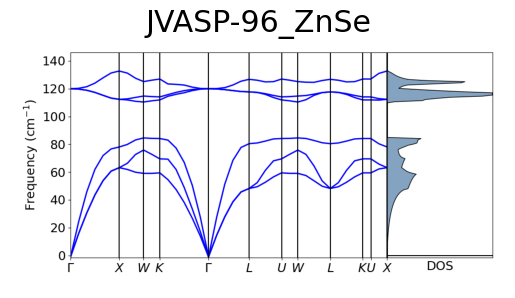

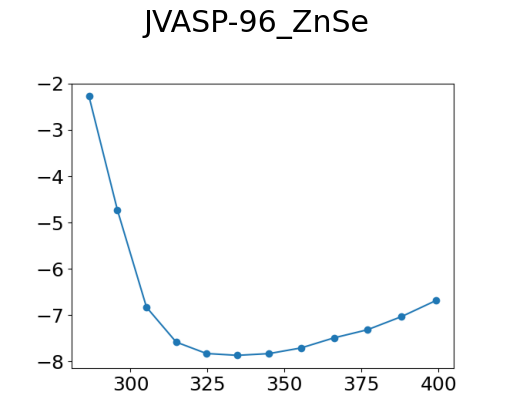

 81%|████████  | 29/36 [1:06:06<08:21, 71.61s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te

      Step     Time          Energy          fmax
FIRE:    0 09:55:43       -0.015809        0.007447
1.2122764587402344 System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te




100%|██████████| 12/12 [00:03<00:00,  3.27it/s]


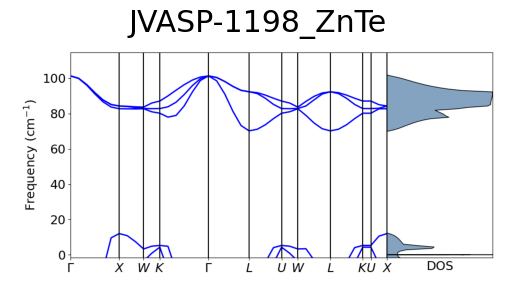

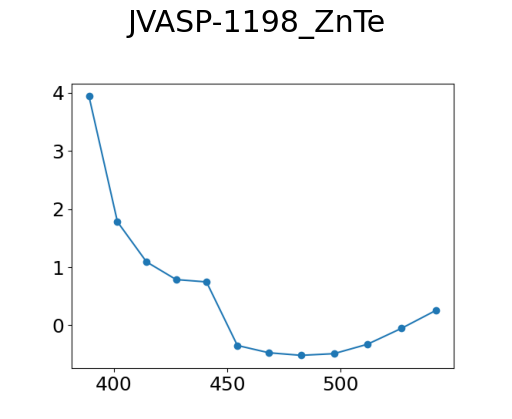

 83%|████████▎ | 30/36 [1:06:52<06:22, 63.76s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6347417036915457 -2.8314567805253072 0.0
1.6347417036915457 2.8314567805253072 0.0
0.0 0.0 5.289073367430449
Zn O 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4989819752523941 Zn
0.3333330000000032 0.6666669999999968 0.9989819752523942 Zn
0.6666669999999968 0.3333330000000032 0.1207080247476044 O
0.3333330000000032 0.6666669999999968 0.6207080247476044 O

      Step     Time          Energy          fmax
FIRE:    0 09:56:30       -6.092616        0.440882
FIRE:    1 09:56:32       -5.741820        0.502614
FIRE:    2 09:56:34       -5.308430        0.508552
FIRE:    3 09:56:36       -5.580821        0.550296
FIRE:    4 09:56:39       -5.780263        0.424788
FIRE:    5 09:56:41       -5.782850        0.379062
FIRE:    6 09:56:44       -5.787076        0.291789
FIRE:    7 09:56


100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


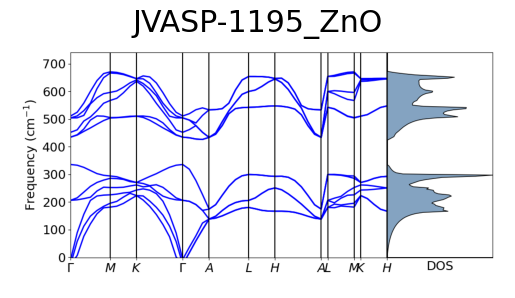

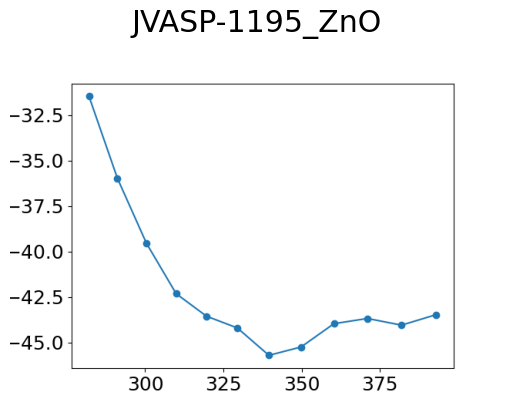

 86%|████████▌ | 31/36 [1:08:55<06:47, 81.56s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
0.0 5.117400519910129 -0.0129583688619494
5.192762305644317 0.0 0.0
0.0 -0.8774675169852882 -5.222730063842967
Hf O 
4 8 
direct
0.7235004611807277 0.541668514756685 0.2919361045049176 Hf
0.27649953881927214 0.0416685147566851 0.2080638954950825 Hf
0.2764995388192722 0.458331485243315 0.7080638954950891 Hf
0.7235004611807277 0.9583314852433151 0.7919361045049109 Hf
0.5530064344320458 0.2580595187702125 0.0204363299877572 O
0.4469935655679546 0.7580595187702126 0.4795636700122431 O
0.44699356556795466 0.7419404812297875 0.979563670012243 O
0.5530064344320458 0.2419404812297875 0.520436329987757 O
0.9286719767960276 0.6638587974986725 0.6583338289137491 O
0.07132802320397172 0.16385879749867252 0.8416661710862509 O
0.0713280232039717 0.3361412025013276 0.3416661710862509 O
0.92867197679602


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
%%time
%matplotlib inline
# Note this is a different model than that published in originall
# https://doi.org/10.1039/D2DD00096B
import matplotlib.pyplot as plt
jids=['JVASP-1002']
jids=jids_check
model_filename='best_model.pt'
model_path = default_path()
aff_lat = []
wiki_lat = []
formulas = []
for jid in tqdm(jids, total=len(jids)):
    s = Atoms.from_dict(get_jid_data(jid=jid, dataset="dft_3d")["atoms"])
    calc = AlignnAtomwiseCalculator(
        path=model_path,
        force_mult_natoms=True,
        force_multiplier=1,
        stress_wt=0.3,
    )
    print(s)
    t1 = time.time()
    formula=s.composition.reduced_formula
    opt = general_relaxer(atoms=s, calculator=calc)
    t2 = time.time()
    aff_lat.append(opt.lattice_mat[0][0])
    formulas.append(s.composition.reduced_formula)
    print(t2 - t1, opt)  # , w cs, mean_absolute_error(iki_lat, aff_lat))
    strains = np.arange(-0.06, 0.06, 0.01)
    vols = []
    ens = []
    for i in tqdm(strains):
        calc = AlignnAtomwiseCalculator(
            path=model_path,
            force_mult_natoms=False,
            force_multiplier=1,
            stress_wt=0.3,
            model_filename=model_filename,
            # stress_wt=-4800,
        )
        sup = opt.make_supercell_matrix([2, 2, 2])
        atms = sup.strain_atoms(i)
        # atms=opt.strain_atoms(i)
        ase_atoms = atms.ase_converter()
        ase_atoms.calc = calc
        en = ase_atoms.get_potential_energy()
        ens.append(en)
        vols.append(atms.volume)
        # vols.append(atms.volume**(1/3))
    plt.plot(vols, ens, "-o")
    fname = "ev_" + jid +"_"+formula+ ".png"
    plt.savefig(fname)
    plt.close()
    atoms = opt.get_primitive_atoms
    name = jid +"_"+formula
    phonopy_bands_figname = "ph_" + name+ ".png"

    phonopy_bands_figname = "ph_" + jid +"_"+formula+ ".png"
    ph = phonons(
        model_path=model_path,
        atoms=atoms,
        phonopy_bands_figname=phonopy_bands_figname,
        force_mult_natoms=True,
    )
    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(phonopy_bands_figname))
    plt.show()
    plt.close()

    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(fname))
    plt.show()
    plt.close()